In [8]:
# imports (this can take some time!)
using DrWatson
@quickactivate "IEEE14"

using NonLinearSystemNeuralNetworkFMU
using ChainRulesCore
#using Zygote
#using BSON
using Flux
using LinearAlgebra
using Statistics
using Plots
#using Metrics
#using Random
#import CSV
#import FMICore
#using Libdl

include("utils.jl")
include("trainSupervised.jl")
include("trainUnsupervised.jl")
include("trainSemiSupervised.jl")

trainModelSemisupervised (generic function with 1 method)

# Introduction
- Comparison between Supervised training, Unsupervised training and a combination of them for learning of SimpleLoop data.
- What is SimpleLoop?: https://github.com/AnHeuermann/NonLinearSystemNeuralNetworkFMU.jl/tree/main/examples/SimpleLoop

SimpleLoop describes a growing circle and a moving line and contains a non-linear system solving for the intersection points of the two objects.
$$r^2 = x^2 + y^2$$
$$rs + b = x + y$$
Inputs to the Surrogate are $r$ and $s$ and $b$ is a parameter.
Output of the Surrogate is $y$ and $x$ can be computed from $y$: $x = rs + b - y$

**Supervised training**:
- input output pairs: $\{(x_{1},y_{1}),...,(x_{N},\;y_{N})\}$
- The loss function is MSE: $$L = \sum_i \big( f(x_i ; \theta)-y^*_i \big)^2$$

**Unsupervised Training**:
- only input, no input output pairs: $\{x_{1},...,x_{N}\}$
- The loss function is measuring the residual of output, which should be $0$ at solution: $$L = \sum_i R(f(x_i ; \theta))$$

**Semi-Supervised Training**:
- input output pairs
- The loss function is combining MSE and residual information: $$L = \sum_i \alpha_0 \big( f(x_i ; \theta)-y^*_i \big)^2 + \alpha_1 R(x_i)$$
- hyperparameters for weighting sum to $1$ with: $\alpha_0 + \alpha_1 = 1$

Clustering:
- applied to output data using KMeans
- idea is to identify unique solutions in data and train on these solutions separately

In [2]:
# data loading into 
fileName = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/data/eq_14.csv"
nInputs = 2
nOutputs = 1

comp, fmu, profilinginfo, vr, row_value_reference, eq_num, sys_num = prepare_fmu("/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/simpleLoop.interface.fmu",
                                                            "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/profilingInfo.bson",
                                                            "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/temp-profiling/simpleLoop.c")

(FMU:            simpleLoop
InstanceName:   simpleLoop
Address:        Ptr{Nothing} @0x00000000094a8300
State:          2
Logging:        0
FMU time:       0.0
FMU states:     nothing, Model name:        simpleLoop
Type:              0, ProfilingInfo[ProfilingInfo(EqInfo(14, 2512, 0.000317798, 1.5827e-5, 0.06756972823105675), ["y"], [11], ["s", "r"], NonLinearSystemNeuralNetworkFMU.MinMaxBoundaryValues{Float64}([0.0, 0.95], [1.4087228258248679, 3.15]))], UInt32[0x00000004], UInt32[0x00000001, 0x00000000], 14, 1)

# Explanation of 1. Experiment
The output data is **first clustered** and then Supervised, Unsupervised and Semi-Supervised are trained. During training, MSE loss and Residual loss on test data is tracked. After training, trained model predictions on test data are plotted in a scatter plot.

In [9]:
# preparation of 1. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)  

# concat in and out data
in_data = hcat(train_in, test_in)
out_data = hcat(train_out, test_out)

x = compute_x_from_y.(in_data[1,:], in_data[2,:], out_data[1,:])
out_data = hcat(x, out_data')'
# cluster out data
cluster_indices, num_clusters = cluster_data(out_data)
# extract cluster
cluster_index = 1
in_data = extract_cluster(in_data, cluster_indices, cluster_index)
out_data = extract_cluster(out_data, cluster_indices, cluster_index)
out_data = out_data[2,:]
out_data = reshape(out_data, 1, length(out_data))
# split one cluster into train and test
train_in, train_out, test_in, test_out = split_train_test(in_data, out_data)
# min max scaling
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)

461-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float64}}, shuffle=true)
  with first element:
  (2×1 Matrix{Float32}, 1×1 Matrix{Float64},)

In [10]:
# definition of the model for all experiments
# simple MLP with one hidden layer
hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)
# Adam optimizer with learning rate 1e-4
opt = Flux.Adam(1e-4)
# training is done for 100 epochs
epochs = 100

100

In [11]:
# 1. experiment
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs, h1=0.8, h2=0.2)

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.010659647292130347, 0.004079715404081195, 0.0033307917173482577, 0.0027842067592298157, 0.0024164916112646953, 0.002001235622631931, 0.0021702983706802397, 0.002065905922541214, 0.0014801188940751846, 0.0013059891729951855  …  9.433113645714649e-6, 1.0717331658895637e-5, 9.911869467713908e-6, 9.907915729917594e-6, 4.260581119957243e-5, 2.101305446524765e-5, 2.280729165016078e-5, 5.819239237387186e-5, 1.6551345634758517e-5, 6.003802433884273e-5], 8.193819999694824)

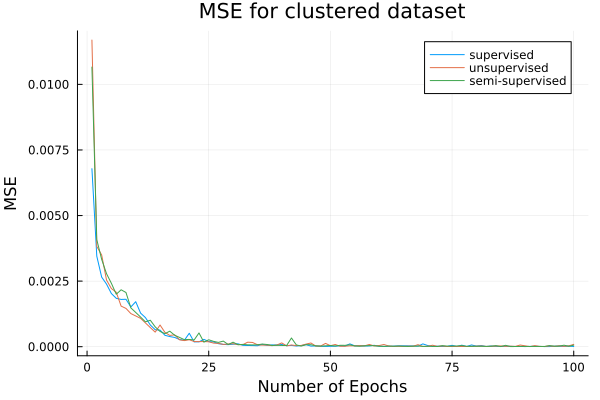

In [12]:
# results of 1. experiment
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
title!("MSE for clustered dataset")
xlabel!("Number of Epochs")
ylabel!("MSE")

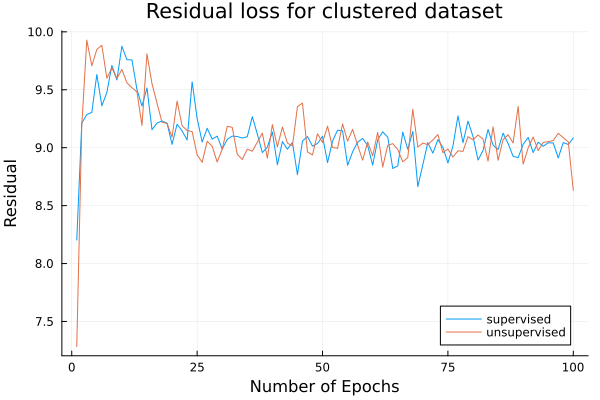

In [13]:
plot_loss_history(res_sup; label="supervised")
plot_loss_history!(res_unsup; label="unsupervised")
title!("Residual loss for clustered dataset")
xlabel!("Number of Epochs")
ylabel!("Residual")

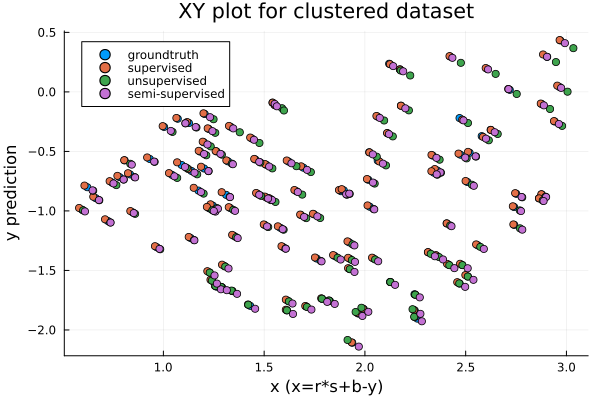

In [14]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth") # reconstruct
plot_xy(supervised_model, test_in, test_out, test_in_t, test_out_t; label="supervised") # reconstruct inside plot xy
plot_xy(unsupervised_model, test_in, test_out, test_in_t, test_out_t; label="unsupervised")
plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised")
title!("XY plot for clustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# Learnings of 1. Experiment
- Unsupervised training **can converge** to a true solution
- Unsupervised training is also **unguided**, it depends on initialization of the parameters to which solution the Network converges, if at all.
- Unsupervised is only superior to Supervised when clustering is not available: more compute while training, unguided
- Semi-Supervised is an option, when a preferred solution and unique data exists: less data generation, guiding of Unsupervised training

# Explanation of 2. Experiment
For the second experiment, the only difference to the first is that **no clustering** is done.

In [15]:
# preparation of 2. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true) #???

900-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true)
  with first element:
  (2×1 Matrix{Float32}, 1×1 Matrix{Float32},)

In [16]:
# 2. experiment
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs, h1=0.8, h2=0.2)

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.0839371f0, 0.0848431f0, 0.08305321f0, 0.08040259f0, 0.08515314f0, 0.08504686f0, 0.083317906f0, 0.08344136f0, 0.08535511f0, 0.08119982f0  …  0.08323684f0, 0.08380494f0, 0.08355048f0, 0.083042175f0, 0.08368414f0, 0.083845556f0, 0.082613565f0, 0.082847185f0, 0.08480028f0, 0.08373735f0], 19.092566967010498)

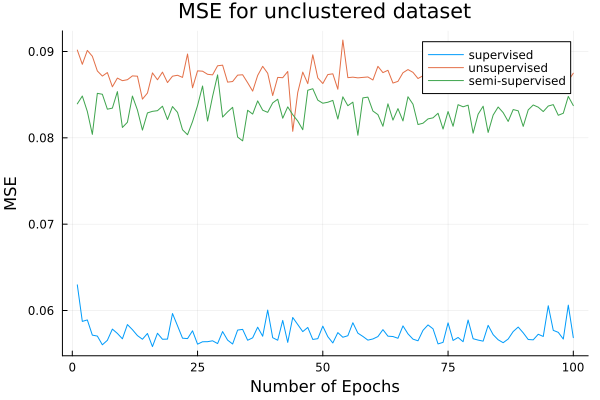

In [17]:
# results of 2. experiment
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
title!("MSE for unclustered dataset")
xlabel!("Number of Epochs")
ylabel!("MSE")

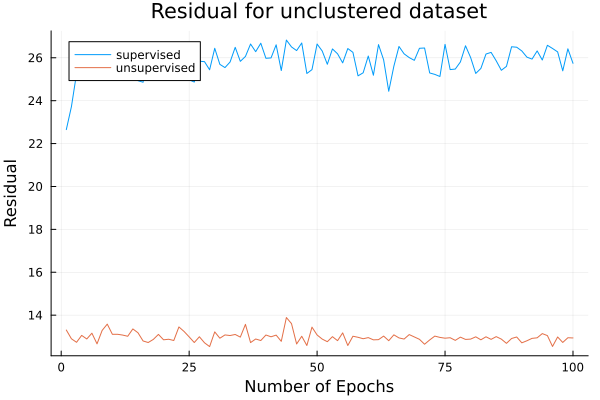

In [18]:
plot_loss_history(res_sup; label="supervised")
plot_loss_history!(res_unsup; label="unsupervised")
title!("Residual for unclustered dataset")
xlabel!("Number of Epochs")
ylabel!("Residual")

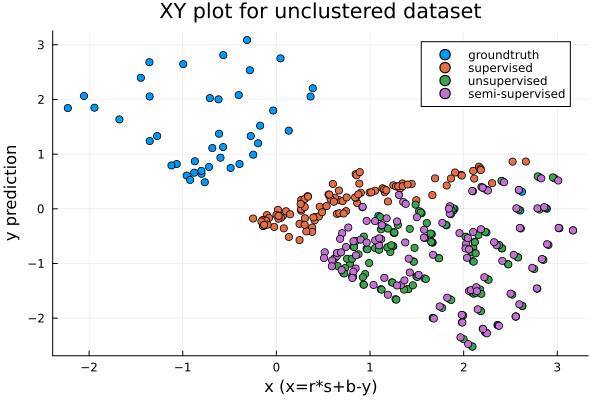

In [19]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth")
plot_xy(supervised_model, test_in, test_out, test_in_t, test_out_t; label="supervised") # reconstruct inside plot xy
plot_xy(unsupervised_model, test_in, test_out, test_in_t, test_out_t; label="unsupervised")
plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised")
title!("XY plot for unclustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# Learnings of 2. Experiment
- Supervised **cant converge on ambigous data**, averaging multiple modes
- Unsupervised **can converge on ambigous data**
- Semi-Supervised needs tuning of hyperparameters to converge, could they be optimized during training?
- loss values can be misleading or residual information is wrong

# Explanation of 3. Experiment
For the third experiment, the **training time of Supervised and Unsupervised** are compared. Both methods are trained for 10, 100 and 1000 epochs and the training time is tracked and compared.

In [20]:
# preparation of 3. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)

epoch_range = [10,100,1000]
gen_unsupervised_data_time = 0.05 # seconds for 1000 datapoints
gen_supervised_data_time = 25 # seconds for 1000 datapoints

25

In [21]:
# 3. experiment unsupervised
full_unsupervised_test_loss_hist = []
full_res_unsupervised_test_loss_hist = []
full_unsupervised_train_time_hist = []
for n_epochs in epoch_range
  unsupervised_model, unsupervised_test_loss_hist, res_unsupervised_test_loss_hist,  unsupervised_time = trainModelUnsupervised(
    deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=n_epochs
    )
    push!(full_unsupervised_test_loss_hist, unsupervised_test_loss_hist[end])
    push!(full_res_unsupervised_test_loss_hist, res_unsupervised_test_loss_hist[end])
    push!(full_unsupervised_train_time_hist, unsupervised_time)
end

In [25]:
# 3. experiment supervised
full_supervised_test_loss_hist = []
full_res_supervised_test_loss_hist = []
full_supervised_train_time_hist = []
for n_epochs in epoch_range
  supervised_model, supervised_test_loss_hist, res_supervised_test_loss_hist, supervised_time = trainModelSupervised(
    deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu;epochs=n_epochs
    )
    push!(full_supervised_test_loss_hist, supervised_test_loss_hist[end])
    push!(full_res_supervised_test_loss_hist, res_supervised_test_loss_hist[end])
    push!(full_supervised_train_time_hist, supervised_time)
end

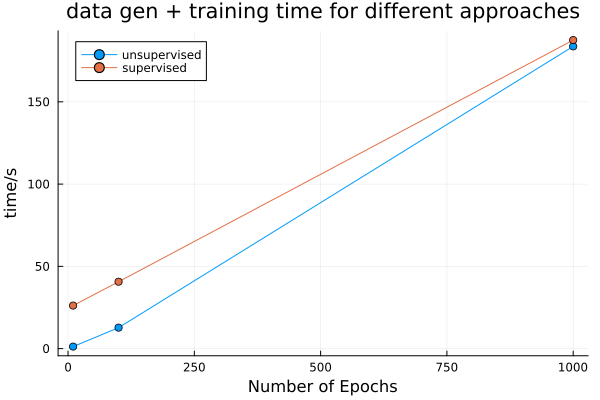

In [26]:
# results of 3. experiment
plot_loss_history(full_unsupervised_train_time_hist .+ gen_unsupervised_data_time, epoch_range; label="unsupervised", marker = :circle)
plot_loss_history!(full_supervised_train_time_hist .+ gen_supervised_data_time, epoch_range; label="supervised", marker = :circle)
title!("data gen + training time for different approaches")
xlabel!("Number of Epochs")
ylabel!("time/s")

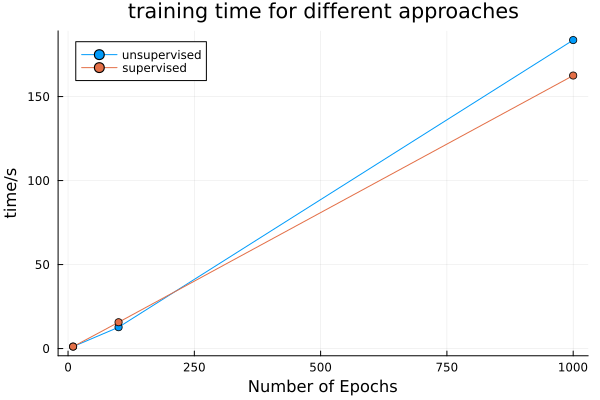

In [27]:
# results of 3. experiment
plot_loss_history(full_unsupervised_train_time_hist, epoch_range; label="unsupervised", marker = :circle)
plot_loss_history!(full_supervised_train_time_hist, epoch_range; label="supervised", marker = :circle)
title!("training time for different approaches")
xlabel!("Number of Epochs")
ylabel!("time/s")

# Learnings of 3. Experiment
- training time increases linearly with number of epochs
- unsupervised data generation is **~500 times faster** than supervised data generation
- actual training time of Supervised is lower than Unsupervised

# Explanation of 4. Experiment
In the fourth experiment, Unsupervised training is compared for **different batchsizes**, namely 1 and 8.

In [28]:
# preparation of 4. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader_1 = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)
dataloader_8 = Flux.DataLoader((train_in, train_out), batchsize=8, shuffle=true)

113-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=8)
  with first element:
  (2×8 Matrix{Float32}, 1×8 Matrix{Float32},)

In [29]:
# 4. experiment
unsupervised_model_1, unsupervised_test_loss_hist_1, res_unsupervised_test_loss_hist_1,  unsupervised_time_1 = trainModelUnsupervised(
    deepcopy(model), deepcopy(opt), dataloader_1, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs
    )

unsupervised_model_8, unsupervised_test_loss_hist_8, res_unsupervised_test_loss_hist_8,  unsupervised_time_8 = trainModelUnsupervised(
  deepcopy(model), deepcopy(opt), dataloader_8, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs
  )

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.12253396f0, 0.10085822f0, 0.09186797f0, 0.08997824f0, 0.09952495f0, 0.0903446f0, 0.095905274f0, 0.08554984f0, 0.08578562f0, 0.08538671f0  …  0.08352859f0, 0.095159635f0, 0.089187756f0, 0.0871879f0, 0.0947864f0, 0.09121409f0, 0.0917961f0, 0.08188244f0, 0.0957415f0, 0.08113564f0], Any[1.6908175329370099, 1.1197429330502564, 1.0255994858800226, 0.9735029191234209, 0.6897406545184385, 0.8141586093146258, 0.6261498496142989, 0.9101697061365387, 0.8750144665144951, 0.8826549962324174  …  0.9305806820024368, 0.4204714477982197, 0.6671282258224459, 0.7645272107373939, 0.43104454600061803, 0.5796567542871773, 0.5517682763275973, 1.0394870477914464, 0.41277077363180714, 1.0476001806180073], 2.6658170223236084)

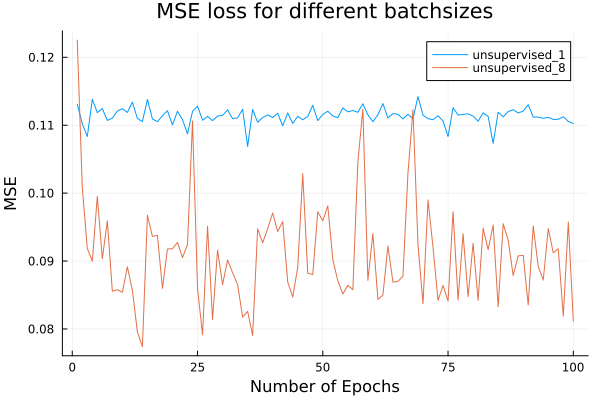

In [30]:
# results of 4. experiment
plot_loss_history(unsupervised_test_loss_hist_1; label="unsupervised_1")
plot_loss_history!(unsupervised_test_loss_hist_8; label="unsupervised_8")
title!("MSE loss for different batchsizes")
xlabel!("Number of Epochs")
ylabel!("MSE")

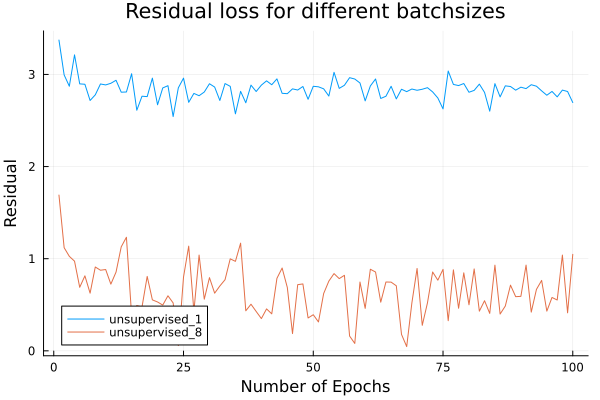

In [31]:
plot_loss_history(res_unsupervised_test_loss_hist_1; label="unsupervised_1")
plot_loss_history!(res_unsupervised_test_loss_hist_8; label="unsupervised_8")
title!("Residual loss for different batchsizes")
xlabel!("Number of Epochs")
ylabel!("Residual")

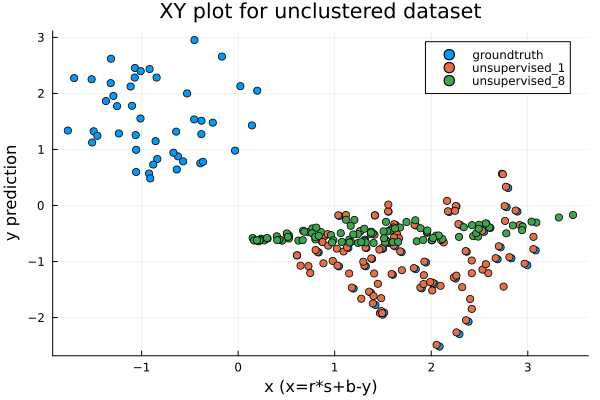

In [32]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth")
plot_xy(unsupervised_model_1, test_in, test_out, test_in_t, test_out_t; label="unsupervised_1")
plot_xy(unsupervised_model_8, test_in, test_out, test_in_t, test_out_t; label="unsupervised_8")
title!("XY plot for unclustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# Learnings of 4. Experiment
- Unsupervised is probably useless cause **bigger batchsize leads to problems**.
- possible reasons: no backprop through reconstruct, if no reconstruct finite diff works out but prediction is way off, current gradient computation doesnt account for reconstruct
- maybe batchsize factor is wrong
- transpose(jac) * res is correct
- "linear" prediction

# IEEE14 Unsupervised
Now Unsupervised is investigated in a **high dimensional scenario** with 15 inputs and 110 outputs. The loss on test data is tracked and the model predictions are plotted in 3D using PCA. In addition to Supervised, Unsupervised and Semi-Supervised, a Two-Step training procedure is tested which trains Unsupervised for the first half of epochs and Supervised with freezed layers for second half of epochs.

In [47]:
using MultivariateStats
include("trainTwoStep.jl")

trainTwoStep (generic function with 1 method)

In [48]:
# IEEE14 residual
fileName = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/data/eq_1403.csv"
nInputs = 16
nOutputs = 110


comp, fmu, profilinginfo, vr, row_value_reference, eq_num, sys_num = prepare_fmu(
  "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/IEEE_14_Buses.interface.fmu",
  "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/profilingInfo.bson",
  "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/temp-profiling/IEEE_14_Buses.c")

# 1. some UNAMBIGOUS dataset and train all methods for performance
# prepare train and test data
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)

┌ Warning: No variable named 'time' found.
└ @ FMIImport /home/fbrandt3/.julia/packages/FMIImport/qrNjL/src/FMI2/convert.jl:153
┌ Warning: Value reference for variable 'time' not found, skipping.
└ @ FMIImport /home/fbrandt3/.julia/packages/FMIImport/qrNjL/src/FMI2/convert.jl:76


(Float32[0.35948175 0.9559515 … 0.53265256 0.24019377; 0.3326428 0.3310271 … 0.32135996 0.30424982; … ; 1.3180994 1.2913542 … 1.3035702 1.2748893; -0.32393277 -0.3382095 … -0.3568024 -0.3487753], Float32[-0.050864555 -0.0079533225 … -0.06540665 -0.06615956; 0.034985464 0.025029758 … 0.03553134 0.034857996; … ; 0.9741079 0.7130459 … 0.98808795 0.9720783; -0.39049247 -0.27677777 … -0.39769366 -0.39628217], Float32[0.010818904 0.012950398 … 1.0460813 1.0464131; 0.31425664 0.3208742 … 0.30677056 0.30945113; … ; 1.216497 1.2874532 … 1.2844564 1.2907441; -0.34767753 -0.3640578 … -0.34286198 -0.35341045], Float32[-0.07043006 -0.056438025 … -0.0166396 -0.014261542; 0.034283217 0.03396835 … 0.025769606 0.025180768; … ; 0.95051235 0.9569465 … 0.730705 0.7195664; -0.3811713 -0.40013215 … -0.28302202 -0.28212985])

In [49]:
CLUSTER = true
if CLUSTER
  # concat in and out data
  in_data = hcat(train_in, test_in)
  out_data = hcat(train_out, test_out)

  # cluster out data
  cluster_indices, num_clusters = cluster_data(out_data)
  # extract cluster
  cluster_index = 1 #rand(1:num_clusters)
  in_data = extract_cluster(in_data, cluster_indices, cluster_index)
  out_data = extract_cluster(out_data, cluster_indices, cluster_index)
else
  # take time out, probably earlier
  in_data = hcat(train_in, test_in)
  out_data = hcat(train_out, test_out)
end

┌ Warning: The clustering cost increased at iteration #11
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/JwhfU/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/JwhfU/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #20
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/JwhfU/src/kmeans.jl:191


110×957 Matrix{Float32}:
 -0.0508646  -0.0509684  -0.0594208  …  -0.0621727  -0.0545843  -0.0667384
  0.0349855   0.035321    0.0346634      0.0348002   0.0342654   0.0357843
  0.170444    0.155559    0.146032       0.171497    0.148642    0.174148
 -0.129893   -0.115422   -0.10632       -0.131381   -0.10868    -0.133004
  0.197451    0.203993    0.251725       0.17484     0.142981    0.209633
  0.091651    0.111877    0.120649   …   0.0525863   0.0273594   0.119041
  0.8404      0.858847    0.874525       0.831978    0.833091    0.878757
  0.0981226   0.100067    0.0992193      0.0971945   0.0963817   0.101175
  0.181349    0.183185    0.229557       0.16776     0.141514    0.187229
 -0.0460361  -0.0451454  -0.0450593     -0.0460446  -0.0458392  -0.047013
  ⋮                                  ⋱               ⋮          
  0.940377    0.945305    0.931139       0.932074    0.926381    0.957657
 -0.382885   -0.373888   -0.37488       -0.3791     -0.381698   -0.388691
 -0.402745   -0.3934

In [50]:
# Warning: No variable named 'time' found.
in_data = in_data[2:end,:]  # take time variable out of in data

15×957 Matrix{Float32}:
  0.332643      0.322         0.328985     …   0.323557     0.320165
  0.130626      0.126554      0.132495         0.130654     0.131812
  1.02383       1.08064       1.06393          1.00774      1.08036
  0.00808735    0.00773769    0.00515304       0.00568397   0.00423951
  1.21672       1.19802       1.18225          1.24383      1.19318
 -0.342917     -0.32781      -0.342414     …  -0.33176     -0.331259
  1.11295       1.13469       1.10693          1.1673       1.17109
  0.00138046    0.00122801    0.00131852       0.00121505   0.00134615
  0.0945406     0.100173      0.0976355        0.0974604    0.0935284
  1.26187       1.20473       1.27264          1.16572      1.24193
  0.224149      0.210916      0.211123     …   0.212691     0.229856
 -0.383087     -0.389175     -0.3878          -0.383813    -0.365913
  0.000848107   0.000123483   0.000261965     -0.00237996   0.000217299
  1.3181        1.2683        1.22393          1.26351      1.31687
 -0.323

In [51]:
# split one cluster into train and test
train_in, train_out, test_in, test_out = split_train_test(in_data, out_data)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=8, shuffle=true)

96-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=8)
  with first element:
  (15×8 Matrix{Float32}, 110×8 Matrix{Float32},)

In [52]:
hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs-1, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)

opt = Flux.Adam(1e-4)
epochs = 100

100

In [53]:
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs, h1=0.8, h2=0.2)
twost_model, twost_test_loss_hist, twost_time = trainTwoStep(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)

(Chain(Dense(15 => 100, relu), Dense(100 => 100, relu), Dense(100 => 100, relu), Dense(100 => 100, relu), Dense(100 => 110)), Any[0.21149415f0, 0.13693951f0, 0.10127646f0, 0.08656792f0, 0.07881297f0, 0.074598536f0, 0.07126415f0, 0.06988537f0, 0.06940596f0, 0.06839193f0  …  0.032254674f0, 0.03216242f0, 0.032115858f0, 0.032016866f0, 0.031911004f0, 0.031804193f0, 0.031704385f0, 0.031639017f0, 0.031543955f0, 0.031408906f0], 0)

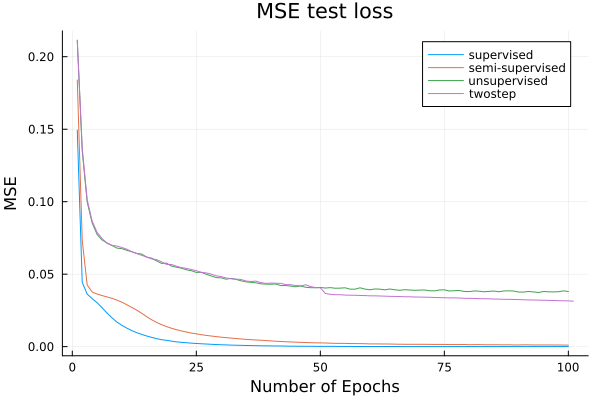

In [54]:
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(twost_test_loss_hist; label="twostep")
title!("MSE test loss")
xlabel!("Number of Epochs")
ylabel!("MSE")

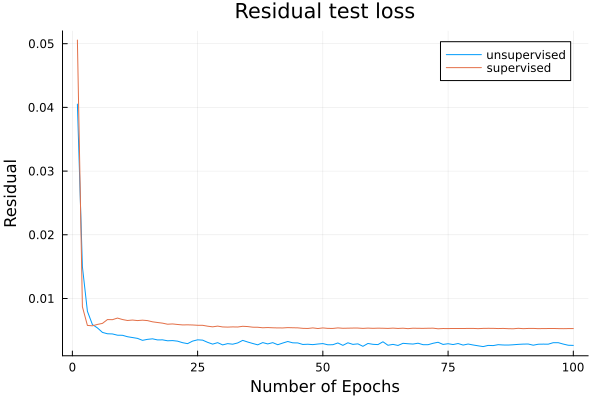

In [55]:
plot_loss_history(res_unsup; label="unsupervised")
plot_loss_history!(res_sup; label="supervised")
title!("Residual test loss")
xlabel!("Number of Epochs")
ylabel!("Residual")

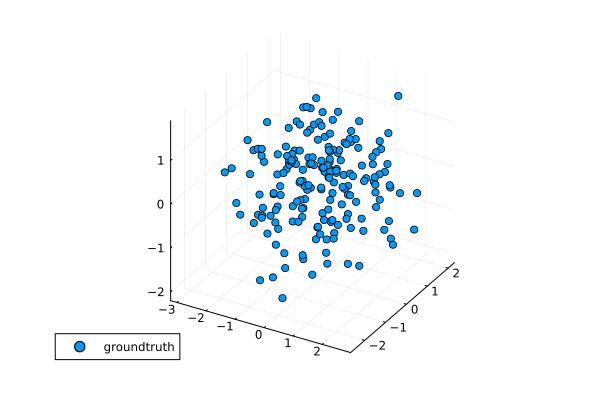

In [56]:
M1 = fit(PCA, test_out; maxoutdim=3)
O1 = predict(M1, test_out)
scatter(O1[1,:],O1[2,:],O1[3,:], label="groundtruth")

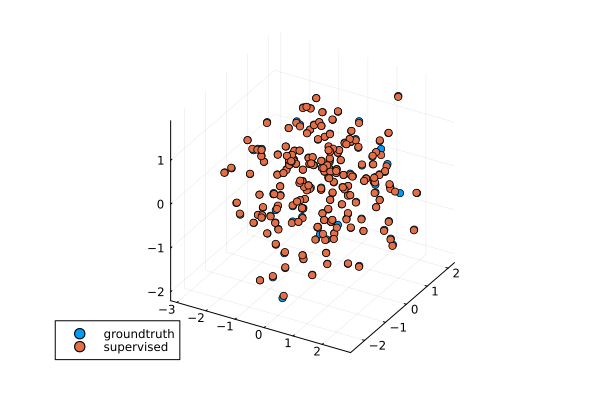

In [57]:
pred3 = supervised_model(test_in)
O3 = predict(M1, pred3)
scatter!(O3[1,:],O3[2,:],O3[3,:], label="supervised")

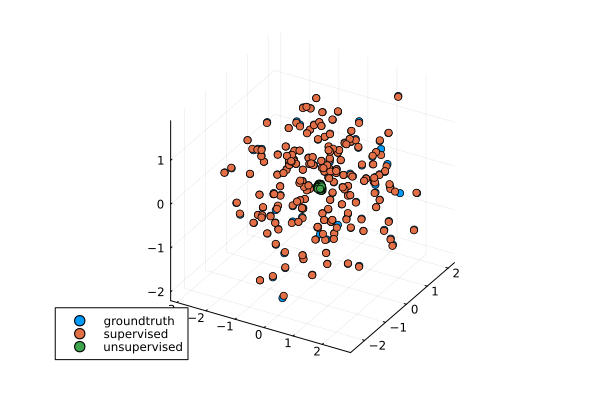

In [58]:
pred2 = unsupervised_model(test_in)
O2 = predict(M1, pred2)
scatter!(O2[1,:],O2[2,:],O2[3,:], label="unsupervised")

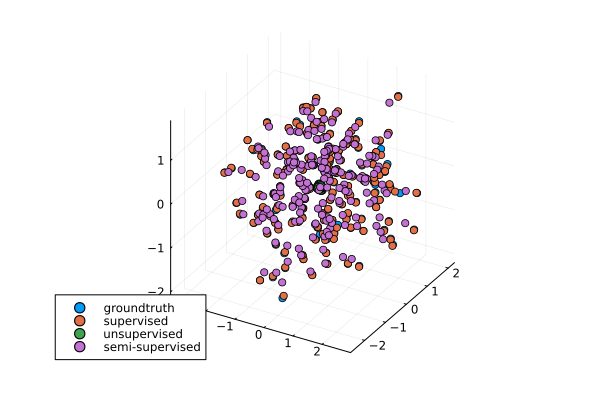

In [59]:
pred4 = semisupervised_model(test_in)
O4 = predict(M1, pred4)
scatter!(O4[1,:],O4[2,:],O4[3,:], label="semi-supervised")

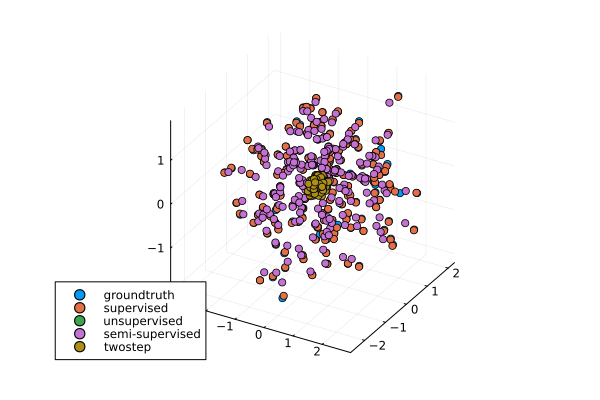

In [60]:
pred5 = twost_model(test_in)
O5 = predict(M1, pred5)
scatter!(O5[1,:],O5[2,:],O5[3,:], label="twostep")

# Learnings of IEEE14
- Unsupervised in higher dimension **does not seem to work well**, because it does not converge.
- The Prediction looks very "linear", just like in 3. experiment, maybe the residual information is wrong
- batchsize 1 doesnt help

# Results/Conclusion of whole Notebook
- fast data generation is good
- If everything is implemented correctly: **Unsupervised works in small dimensions but not in higher dimensions**.

In [62]:
# average multiple runs (BAD CODE I KNOW)
num_runs = 5
mean_loss_hist_sup = []
for i in 1:num_runs
    supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
    if i == 1
        mean_loss_hist_sup = supervised_test_loss_hist
    else
        #mean_loss_hist *= i-1 maybe this
        mean_loss_hist_sup += supervised_test_loss_hist
        mean_loss_hist_sup /= i
    end
end

mean_loss_hist_unsup = []
for i in 1:num_runs
    unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
    if i == 1
        mean_loss_hist_unsup = unsupervised_test_loss_hist
    else
        #mean_loss_hist *= i-1 maybe this
        mean_loss_hist_unsup += unsupervised_test_loss_hist
        mean_loss_hist_unsup /= i
    end
end

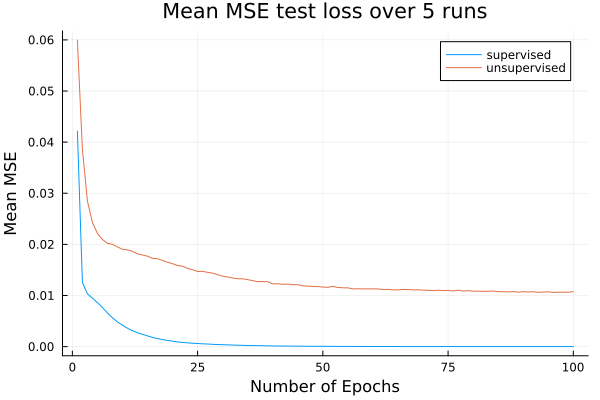

In [65]:
plot_loss_history(mean_loss_hist_sup; label="supervised")
plot_loss_history!(mean_loss_hist_unsup; label="unsupervised")
title!("Mean MSE test loss over $(num_runs) runs")
xlabel!("Number of Epochs")
ylabel!("Mean MSE")

In [6]:
function loss(y_hat, fmu, eq_num, sys_num, transform)
    bs = size(y_hat)[2] # batchsize
    residuals = Array{Vector{Float64}}(undef, bs)
    for j in 1:bs
        yj_hat = StatsBase.reconstruct(transform, y_hat[:,j])
        _, res = NonLinearSystemNeuralNetworkFMU.fmiEvaluateRes(fmu, eq_num, Float64.(yj_hat))
        residuals[j] = res
    end
    return 1/(2*bs)*sum(norm.(residuals).^2), if bs>1 residuals else residuals[1] end
end
  
function ChainRulesCore.rrule(::typeof(loss), x, fmu, eq_num, sys_num, transform)
    l, res = loss(x, fmu, eq_num, sys_num, transform)
    # evaluate the jacobian for each batch element
    bs = size(x)[2] # batchsize
    res_dim = if bs>1 length(res[1]) else length(res) end
    jac_dim = res_dim

    jacobians = Array{Matrix{Float64}}(undef, bs)
    for j in 1:bs
        xj = StatsBase.reconstruct(transform, x[:,j])
        _, jac = NonLinearSystemNeuralNetworkFMU.fmiEvaluateJacobian(comp, sys_num, vr, Float64.(xj))
        jacobians[j] = reshape(jac, (jac_dim,jac_dim))
    end

    function loss_pullback(l̄)
        l_tangent = l̄[1] # upstream gradient
        factor = l_tangent/bs # factor should probably be just: factor=l_tangent!!!!

        x̄ = Array{Float64}(undef, res_dim, bs)
        # compute x̄
        for j in 1:bs
            x̄[:,j] = transpose(jacobians[j]) * res[j]
        end
        x̄ = if transform.dims == 1 x̄ .* (1 ./ transform.scale)' elseif transform.dims == 2 x̄ .* (1 ./ transform.scale) end #!!!!
        x̄ *= factor

        # all other args have NoTangent
        f̄ = NoTangent()
        fmū = NoTangent()
        eq_num̄ = NoTangent()
        sys_num̄ = NoTangent()
        transform̄ = NoTangent()
        return (f̄, x̄, fmū, eq_num̄, sys_num̄, transform̄)
    end

    return l, loss_pullback
end

In [4]:
# preparation of 2. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=8, shuffle=true)

169-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=8)
  with first element:
  (16×8 Matrix{Float32}, 110×8 Matrix{Float32},)

In [5]:
x = first(dataloader)[2]
loss(x, fmu, eq_num, sys_num, train_out_t)

(0.00401936171799463, [[-5.547966086538736e-9, 0.001707572640741506, -0.003977540923603584, 2.4955067783050122e-8, 1.1283587661448102e-8, 2.5895349718696448e-9, 2.1287093754374098e-9, -8.013695479772154e-9, -1.972362399099703e-8, 8.013695479772154e-9  …  -2.45973095294727e-8, -2.680979669170136e-8, -4.337243735691443e-8, 0.0012036726066953357, 0.0011650619344735977, 1.2112744585124346e-8, -4.559265187609185e-10, -5.413597764514222e-10, 0.004280527705804615, -0.04798246822324248], [-4.700794808965014e-9, -0.0008586946374238291, 0.0028438406121608084, -1.3451445846947296e-8, -3.5343132934184673e-9, -8.991718541614957e-9, 2.1919669135339603e-9, -1.9183456899385387e-8, 3.0913949039534927e-9, 1.9183456899385387e-8  …  1.380920410139208e-8, 6.188452250643905e-10, -2.529546618695866e-8, 0.0007892843520026054, 0.0008455083731729179, 4.212952697812966e-8, 2.0192018057585415e-9, 3.9750505248514756e-9, -0.026528811261837648, 0.027282329151639972], [2.7400227642360164e-9, -0.00010491896245945487, 

In [7]:
l, pullb = ChainRulesCore.rrule(loss, x, fmu, eq_num, sys_num, train_out_t)